In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import os
import pynumdiff

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

In [6]:
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax
def compute_distance_svs(u,dx,fd_orders=range(2,8),normalise=None):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        if normalise!=None:
            features = normalise(features)
        svs = svd(features, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

def compute_ratio_svs(u,dx,fd_orders=range(2,8)):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T
        svs = svd(features, compute_uv=False)
        ratio = svs[0]/svs[-1]
        distance_svs.append(ratio)
    return distance_svs

# Exponential function: $u(t,x)=exp(x+at)$

In [27]:
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1
exp(-0.741146843060084*t + x)


Noise level: 0
No normalisation: matrix rank = 1, svd = [1.82673727e+03 2.41130296e-09]
Frobenius normalisation: matrix rank = 1, svd = [1.00000000e+00 1.32000549e-12]
Minmax normalisation: matrix rank = 1, svd = [1.23084589e+01 1.62471653e-11]
Noise level: 1e-10
No normalisation: matrix rank = 2, svd = [1.82673727e+03 1.12187928e-05]
Frobenius normalisation: matrix rank = 2, svd = [1.0000000e+00 6.1414375e-09]
Minmax normalisation: matrix rank = 2, svd = [1.23084589e+01 7.55916309e-08]
Noise level: 1e-09
No normalisation: matrix rank = 2, svd = [1.82673727e+03 1.12188189e-04]
Frobenius normalisation: matrix rank = 2, svd = [1.00000000e+00 6.14145179e-08]
Minmax normalisation: matrix rank = 2, svd = [1.23084589e+01 7.55918071e-07]
Noise level: 1e-08
No normalisation: matrix rank = 2, svd = [1.82673728e+03 1.12188213e-03]
Frobenius normalisation: matrix rank = 2, svd = [1.00000000e+00 6.14145309e-07]
Minmax normalisation: matrix rank = 2, svd = [1.23084589e+01 7.55918233e-06]
Noise leve

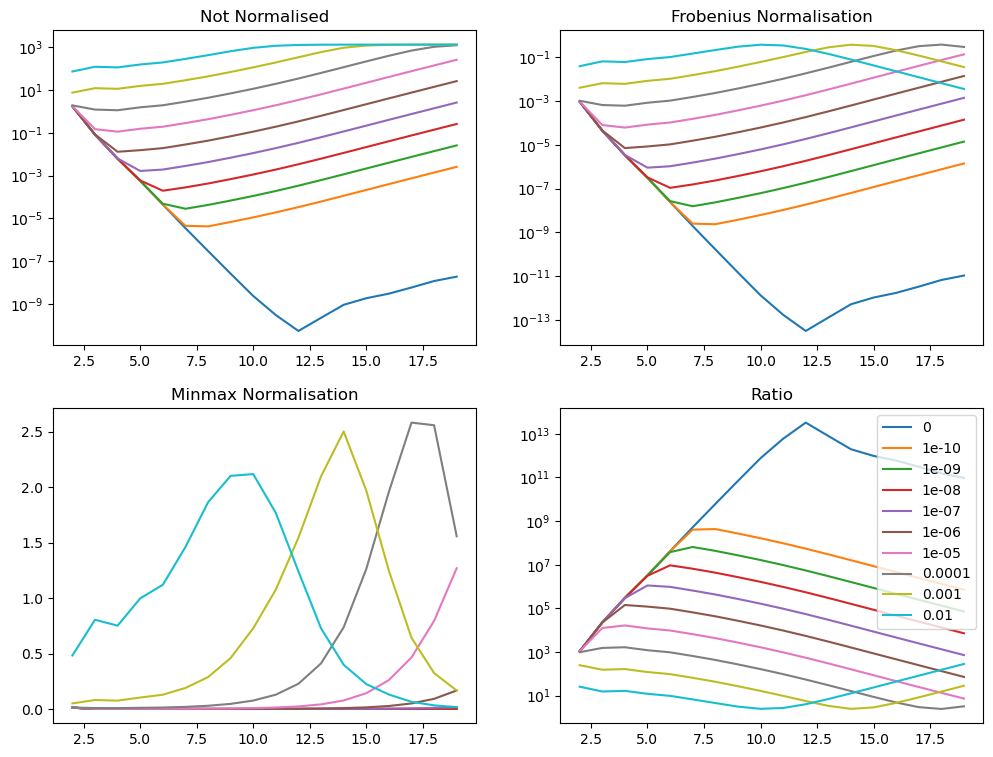

In [29]:
noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.title("Not Normalised")
plt.yscale('log')
plt.subplot(2,2,2)
plt.title("Frobenius Normalisation")
plt.subplot(2,2,3)
plt.title("Minmax Normalisation")
plt.subplot(2,2,4)
plt.title("Ratio")
m=20
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    #Calculate normalisation and print rank and svd
    g_noise_frobenius=normalise_frobenius(g_noise)
    g_noise_minmax=normalise_minmax(g_noise)
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    print(f"No normalisation: matrix rank = {matrix_rank(g_noise)}, svd = {svd(g_noise, compute_uv=False)}")
    print(f"Frobenius normalisation: matrix rank = {matrix_rank(g_noise_frobenius)}, svd = {svd(g_noise_frobenius, compute_uv=False)}")
    print(f"Minmax normalisation: matrix rank = {matrix_rank(g_noise_minmax)}, svd = {svd(g_noise_minmax, compute_uv=False)}")
    #Calculate distances and plot
    distance_svs_noise_frobenius = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_frobenius)
    distance_svs_noise_minmax = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_minmax)
    distance_svs_noise_ratio = compute_ratio_svs(u_noise,dx,fd_orders=range(2,m))
    plt.subplot(2,2,1)
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.subplot(2,2,2)
    plt.plot(range(2,m), distance_svs_noise_frobenius,label=str(target_noise))
    plt.yscale('log')
    plt.subplot(2,2,3)
    plt.plot(range(2,m), distance_svs_noise_minmax,label=str(target_noise))
    plt.subplot(2,2,4)
    plt.plot(range(2,m), distance_svs_noise_ratio,label=str(target_noise))
    plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

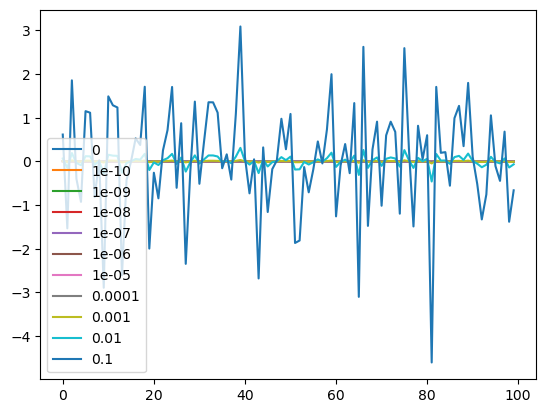

In [17]:
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    plt.plot(u_noise[0],label=str(target_noise))
plt.legend()
#plt.savefig("noise_levels_func.png")
plt.show()


# Exponential function: $u(t,x)=(bt+x)exp(at)$

In [18]:
experiment_name = "linear_unique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_unique_1
(0.326723884469505*t + x)*exp(0.741146843060084*t)


Noise level: 0
No normalisation: matrix rank = 2, svd = [4971.40654551 1348.56946974]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251024  4.99738548]
Noise level: 1e-10
No normalisation: matrix rank = 2, svd = [4971.40654562 1348.56947038]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251025  4.99738548]
Noise level: 1e-09
No normalisation: matrix rank = 2, svd = [4971.40654661 1348.56947619]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251025  4.9973855 ]
Noise level: 1e-08
No normalisation: matrix rank = 2, svd = [4971.40655648 1348.56953423]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180376]
Minmax normalisation: matrix rank = 2, svd = [18.42251029  4.99738572]
Noise level: 1e-07
No normalisation: matrix rank = 2, svd = [4971.406655

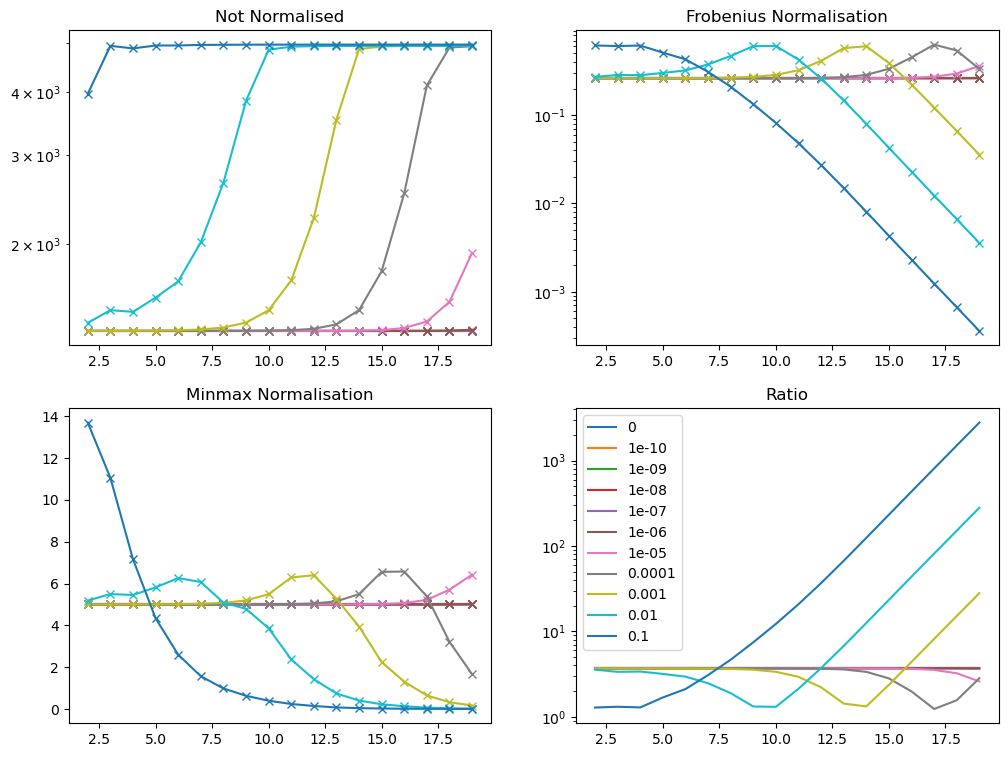

In [23]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.title("Not Normalised")
plt.yscale('log')
plt.subplot(2,2,2)
plt.title("Frobenius Normalisation")
plt.subplot(2,2,3)
plt.title("Minmax Normalisation")
plt.subplot(2,2,4)
plt.title("Ratio")
m=20
fd_orders=range(2,m)
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    #Calculate normalisation and print rank and svd
    g_noise_frobenius=normalise_frobenius(g_noise)
    g_noise_minmax=normalise_minmax(g_noise)
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=fd_orders)
    print(f"No normalisation: matrix rank = {matrix_rank(g_noise)}, svd = {svd(g_noise, compute_uv=False)}")
    print(f"Frobenius normalisation: matrix rank = {matrix_rank(g_noise_frobenius)}, svd = {svd(g_noise_frobenius, compute_uv=False)}")
    print(f"Minmax normalisation: matrix rank = {matrix_rank(g_noise_minmax)}, svd = {svd(g_noise_minmax, compute_uv=False)}")
    #Calculate distances and plot
    distance_svs_noise_frobenius = compute_distance_svs(u_noise,dx,fd_orders=fd_orders,normalise=normalise_frobenius)
    distance_svs_noise_minmax = compute_distance_svs(u_noise,dx,fd_orders=fd_orders,normalise=normalise_minmax)
    distance_svs_noise_ratio = compute_ratio_svs(u_noise,dx,fd_orders=range(2,m))
    plt.subplot(2,2,1)
    plt.plot(fd_orders, distance_svs_noise,label=str(target_noise),marker='x')
    plt.subplot(2,2,2)
    plt.plot(fd_orders, distance_svs_noise_frobenius,label=str(target_noise),marker='x')
    plt.yscale('log')
    plt.subplot(2,2,3)
    plt.plot(fd_orders, distance_svs_noise_minmax,label=str(target_noise),marker='x')
    plt.subplot(2,2,4)
    plt.plot(range(2,m), distance_svs_noise_ratio,label=str(target_noise))
plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")